# ICU-Predictor (cleaned)

This notebook has been cleaned: filler, duplicate, and non-working cells were removed.
Sections kept: concise data-download attempt, preprocessing, sequence creation, and model training examples.

## Dataset
This notebook attempts to download the `salikhussaini49/prediction-of-sepsis` dataset using `kagglehub`. If automatic download fails, set `dataset_path` to a local path containing `Dataset.csv`.

In [2]:
# Install lightweight helper (optional)
# You can comment this out if packages are already installed.
try:
    import kagglehub
    print('kagglehub already installed')
except Exception:
    import sys
    !{sys.executable} -m pip install --quiet kagglehub
    import kagglehub
    print('kagglehub installed')

kagglehub already installed


/home/tired_atlas/miniconda3/envs/AI-Health/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Try to download dataset via kagglehub; if it fails, set a fallback dataset_path.
dataset_path = None
try:
    import kagglehub
    print('Attempting kagglehub.dataset_download...')
    dataset_path = kagglehub.dataset_download('salikhussaini49/prediction-of-sepsis')
    print('Downloaded dataset to:', dataset_path)
except Exception as e:
    print('kagglehub download failed:', str(e))
    # Fallback: common kagglehub cache location used in this notebook before.
    dataset_path = '/root/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2'
    print('Using fallback dataset_path:', dataset_path)

# Verify existence (user should edit if different)
import os
if not os.path.exists(dataset_path):
    print('Warning: dataset_path does not exist:', dataset_path)
    print('If dataset is local, set dataset_path to the folder that contains Dataset.csv')

Attempting kagglehub.dataset_download...
Downloaded dataset to: /home/tired_atlas/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2
Downloaded dataset to: /home/tired_atlas/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2


In [4]:
# Consolidated: load data, preprocess, create sequences, and train a simple RNN for 1 epoch.
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

if dataset_path is None or not os.path.exists(dataset_path):
    raise FileNotFoundError(f'Dataset path not found: {dataset_path}. Please set dataset_path to the folder that contains Dataset.csv')

csv_file = os.path.join(dataset_path, 'Dataset.csv')
if not os.path.exists(csv_file):
    raise FileNotFoundError(f'Dataset.csv not found in {dataset_path}')

print('Loading Dataset.csv...')
df = pd.read_csv(csv_file)
print('Raw dataframe shape:', df.shape)

# Basic cleanup (drop auto index if present)
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Identify features and target
if 'SepsisLabel' not in df.columns or 'Patient_ID' not in df.columns:
    raise ValueError('Expected columns `SepsisLabel` and `Patient_ID` in Dataset.csv')

exclude_cols = ['SepsisLabel', 'Patient_ID', 'Hour'] if 'Hour' in df.columns else ['SepsisLabel', 'Patient_ID']
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
feature_cols = [c for c in numerical_cols if c not in exclude_cols]
print(f'Found {len(feature_cols)} numerical feature columns.')



print("Handling missing values (Patient-Specific Strategies)...")
for col in feature_cols:
    # 1. Forward Fill (Carry forward the last known value for the patient)
    # This is crucial for time-series (e.g., BP measured 2 hours ago is still relevant)
    df[col] = df.groupby('Patient_ID')[col].ffill()
    
    # 2. Backward Fill (If the sequence starts with NaNs, look ahead)
    df[col] = df.groupby('Patient_ID')[col].bfill()
    
    # 3. [NEW] Patient Mean Imputation
    # If gaps remain, fill with that SPECIFIC PATIENT'S mean for that feature
    if df[col].isnull().any():
        patient_means = df.groupby('Patient_ID')[col].transform('mean')
        df[col] = df[col].fillna(patient_means)
        
    # 4. Final Fallback (Global Mean)
    # If a patient has NO values for a feature (e.g. no Lactate measured ever), 
    # patient_mean is NaN. We must fill this to avoid model crashes.
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mean())

y = df['SepsisLabel']
X = df[feature_cols]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

# Patient-wise split
unique_patient_ids = df['Patient_ID'].unique()
pid_train, pid_temp = train_test_split(unique_patient_ids, test_size=0.3, random_state=42)
pid_val, pid_test = train_test_split(pid_temp, test_size=0.5, random_state=42)

df_train = df[df['Patient_ID'].isin(pid_train)]
df_val = df[df['Patient_ID'].isin(pid_val)]
df_test = df[df['Patient_ID'].isin(pid_test)]

# Sequence creation helper
def create_sequences(patient_df, X_scaled_data, y_data):
    X_seq = []
    y_seq = []
    for pid in patient_df['Patient_ID'].unique():
        idx = df[df['Patient_ID'] == pid].index
        X_seq.append(X_scaled_data.loc[idx].values)
        y_seq.append(y_data.loc[idx].values)
    return X_seq, y_seq

X_train_list, y_train_list = create_sequences(df_train, X_scaled_df, y)
X_val_list, y_val_list = create_sequences(df_val, X_scaled_df, y)
X_test_list, y_test_list = create_sequences(df_test, X_scaled_df, y)

max_seq = max(max(len(s) for s in X_train_list), max(len(s) for s in X_val_list), max(len(s) for s in X_test_list))
print('Max sequence length:', max_seq)

X_train_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
y_train_seq = tf.keras.preprocessing.sequence.pad_sequences(y_train_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
X_val_seq = tf.keras.preprocessing.sequence.pad_sequences(X_val_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
y_val_seq = tf.keras.preprocessing.sequence.pad_sequences(y_val_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
X_test_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
y_test_seq = tf.keras.preprocessing.sequence.pad_sequences(y_test_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)

print('Shapes: ', X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape)

# Simple RNN model (sequence-to-sequence) - train 1 epoch as a sanity check
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
rnn_model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    TimeDistributed(Dense(1, activation='sigmoid'))
])
rnn_model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC(name='auc')])
rnn_model.summary()

print('Training RNN for 1 epoch (sanity check)...')
history = rnn_model.fit(X_train_seq, y_train_seq, epochs=1, batch_size=64, validation_data=(X_val_seq, y_val_seq))
print('RNN training finished (1 epoch).')

2025-12-16 14:38:02.185643: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 14:38:02.253656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765892282.264840    5116 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765892282.269279    5116 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765892282.320991    5116 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Loading Dataset.csv...
Raw dataframe shape: (1552210, 44)
Found 40 numerical feature columns.
Handling missing values (Patient-Specific Strategies)...
Raw dataframe shape: (1552210, 44)
Found 40 numerical feature columns.
Handling missing values (Patient-Specific Strategies)...
Max sequence length: 336
Max sequence length: 336
Shapes:  (28235, 336, 40) (28235, 336) (6050, 336, 40) (6050, 336)
Shapes:  (28235, 336, 40) (28235, 336) (6050, 336, 40) (6050, 336)


I0000 00:00:1765892321.415040    5116 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5142 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5060 Ti, pci bus id: 0000:01:00.0, compute capability: 12.0
/home/tired_atlas/miniconda3/envs/AI-Health/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 336, 128)       │        21,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 336, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 336, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,761 (85.00 KB)

 Trainable params: 21,761 (85.00 KB)

 Non-trainable params: 0 (0.00 B)

Training RNN for 1 epoch (sanity check)...


I0000 00:00:1765892326.802384    6759 service.cc:152] XLA service 0x7f99280e8980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765892326.802403    6759 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 5060 Ti, Compute Capability 12.0
2025-12-16 14:38:46.986118: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765892328.107220    6759 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1765892328.107220    6759 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-16 14:39:05.291402: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_multiply_fusion', 264 bytes spill stores, 196 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_11', 468 bytes spill st

442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9553 - auc: 0.8548 - loss: 0.1094 - precision: 0.0151 - recall: 0.2488

2025-12-16 14:39:34.671825: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_multiply_fusion_1', 924 bytes spill stores, 1024 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_11', 512 bytes spill stores, 508 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_10', 512 bytes spill stores, 508 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_9', 16 bytes spill stores, 16 bytes spill loads



442/442 ━━━━━━━━━━━━━━━━━━━━ 65s 95ms/step - accuracy: 0.9854 - auc: 0.8516 - loss: 0.0407 - precision: 0.0182 - recall: 0.1177 - val_accuracy: 0.9975 - val_auc: 0.8702 - val_loss: 0.0125 - val_precision: 0.0910 - val_recall: 0.0190
RNN training finished (1 epoch).
RNN training finished (1 epoch).


2025-12-16 14:39:47.506674: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_compare_reduce_fusion', 12 bytes spill stores, 8 bytes spill loads



In [5]:
# CNN model example (sequence-to-sequence) - keeps sequence length by using padding='same'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
    Dropout(0.2),
    Conv1D(128, 3, activation='relu', padding='same'),
    Dropout(0.2),
    TimeDistributed(Dense(1, activation='sigmoid'))
])
cnn_model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC(name='auc')])
cnn_model.summary()

print('Training CNN for 1 epoch (sanity check)...')
history_cnn = cnn_model.fit(X_train_seq, y_train_seq, epochs=1, batch_size=64, validation_data=(X_val_seq, y_val_seq))
print('CNN training finished (1 epoch).')

/home/tired_atlas/miniconda3/envs/AI-Health/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 336, 64)        │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 336, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 336, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 336, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 336, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,577 (127.25 KB)

 Trainable params: 32,577 (127.25 KB)

 Non-trainable params: 0 (0.00 B)

Training CNN for 1 epoch (sanity check)...
  1/442 ━━━━━━━━━━━━━━━━━━━━ 2:46:22 23s/step - accuracy: 0.9690 - auc: 0.2333 - loss: 0.6788 - precision_1: 0.0093 - recall_1: 0.2000

2025-12-16 14:40:10.744259: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 112 bytes spill stores, 64 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_8', 488 bytes spill stores, 488 bytes spill loads



442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9975 - auc: 0.4480 - loss: 0.1512 - precision_1: 0.0169 - recall_1: 0.0047

2025-12-16 14:40:31.648716: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion_1', 444 bytes spill stores, 444 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_8', 512 bytes spill stores, 508 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_7', 512 bytes spill stores, 508 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_6', 16 bytes spill stores, 16 bytes spill loads



442/442 ━━━━━━━━━━━━━━━━━━━━ 55s 74ms/step - accuracy: 0.9979 - auc: 0.6610 - loss: 0.0535 - precision_1: 0.0179 - recall_1: 7.2977e-04 - val_accuracy: 0.9978 - val_auc: 0.8450 - val_loss: 0.0144 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
CNN training finished (1 epoch).
CNN training finished (1 epoch).


2025-12-16 14:40:43.689045: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_compare_reduce_fusion', 12 bytes spill stores, 8 bytes spill loads



In [6]:
# LGSTM (layered LSTM) model: stacked LSTM layers for sequence-to-sequence prediction
from tensorflow.keras.layers import LSTM, Bidirectional

print('Defining LGSTM (stacked LSTM) model...')
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

lgstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(1, activation='sigmoid'))
])

lgstm_model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC(name='auc')])
lgstm_model.summary()

print('Training LGSTM for 3 epochs (adjust as needed)...')
history_lgstm = lgstm_model.fit(X_train_seq, y_train_seq, epochs=3, batch_size=64, validation_data=(X_val_seq, y_val_seq))
print('LGSTM training finished.')

Defining LGSTM (stacked LSTM) model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 336, 128)       │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 336, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 336, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 336, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 336, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,001 (531.25 KB)

 Trainable params: 136,001 (531.25 KB)

 Non-trainable params: 0 (0.00 B)

Training LGSTM for 3 epochs (adjust as needed)...
Epoch 1/3
Epoch 1/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.9967 - auc: 0.7778 - loss: 0.0264 - precision_2: 0.0167 - recall_2: 0.0106 - val_accuracy: 0.9978 - val_auc: 0.9271 - val_loss: 0.0111 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.9967 - auc: 0.7778 - loss: 0.0264 - precision_2: 0.0167 - recall_2: 0.0106 - val_accuracy: 0.9978 - val_auc: 0.9271 - val_loss: 0.0111 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9980 - auc: 0.9221 - loss: 0.0100 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.9978 - val_auc: 0.9218 - val_loss: 0.0102 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9980 - auc: 0.9221 - loss: 0.0100 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val

190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Evaluation for LGSTM:
  AUC: 0.9747, AP: 0.0702
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Confusion matrix:
 [[2028831       0]
 [   4305       0]]
Evaluation for LGSTM:
  AUC: 0.9747, AP: 0.0702
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Confusion matrix:
 [[2028831       0]
 [   4305       0]]
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step
Evaluation for CNN:
  AUC: 0.7901, AP: 0.0469
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Confusion matrix:
 [[2028831       0]
 [   4305       0]]
Evaluation for CNN:
  AUC: 0.7901, AP: 0.0469
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Confusion matrix:
 [[2028831       0]
 [   4305       0]]
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
Evaluation for RNN:
  AUC: 0.9635, AP: 0.0325
  Precision: 0.0399, Recall: 0.0072, F1: 0.0122
  Confusion matrix:
 [[2028085  

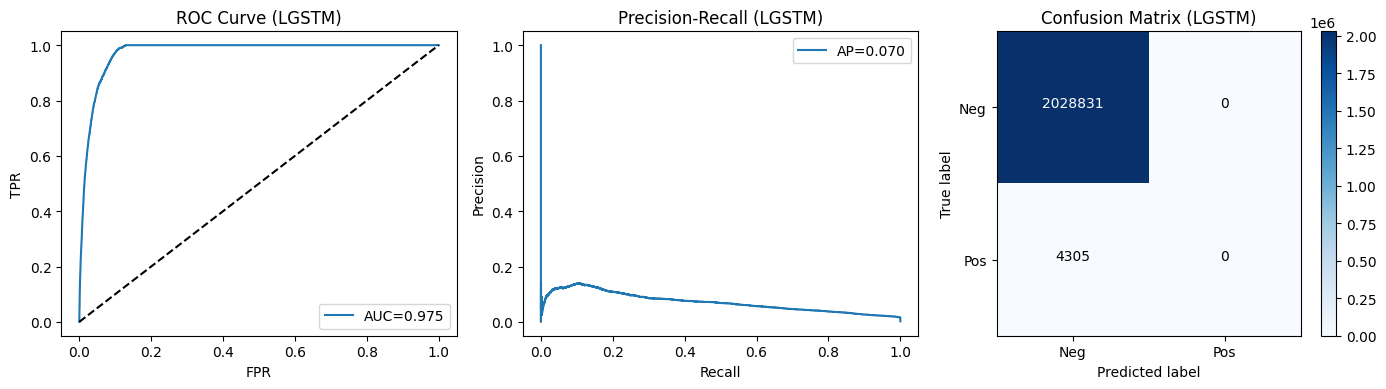

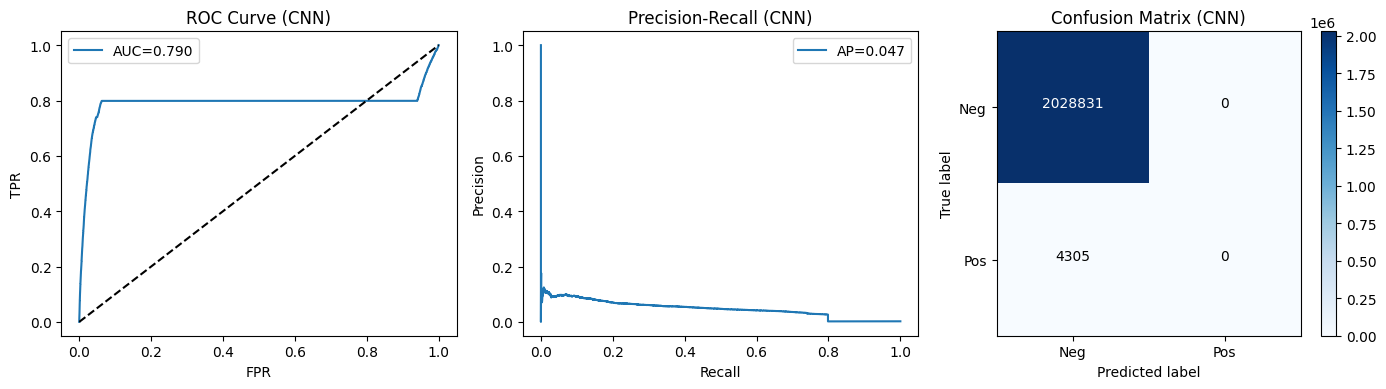

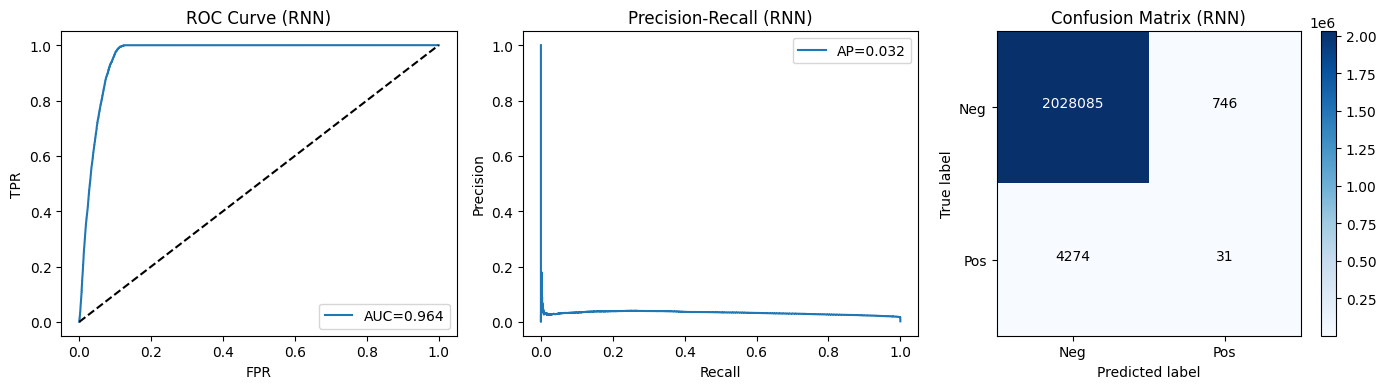

In [7]:
# Evaluation: aggregate per-timestep predictions into flattened arrays and compute metrics
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes=['Neg','Pos'], title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def evaluate_sequence_model(model, X_seq, y_seq, threshold=0.5, name='model'):
    # Predict probabilities (shape: samples, seq_len, 1)
    preds = model.predict(X_seq)
    preds_flat = preds.reshape(-1)
    y_flat = y_seq.reshape(-1)

    # Note: padded timesteps are kept. If you have original lengths, mask padded positions.

    auc = roc_auc_score(y_flat, preds_flat)
    avg_prec = average_precision_score(y_flat, preds_flat)
    y_pred_bin = (preds_flat >= threshold).astype(int)
    prec = precision_score(y_flat, y_pred_bin, zero_division=0)
    rec = recall_score(y_flat, y_pred_bin, zero_division=0)
    f1 = f1_score(y_flat, y_pred_bin, zero_division=0)
    cm = confusion_matrix(y_flat, y_pred_bin)

    print(f"Evaluation for {name}:")
    print(f"  AUC: {auc:.4f}, AP: {avg_prec:.4f}")
    print(f"  Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print('  Confusion matrix:\n', cm)

    # ROC curve
    from sklearn.metrics import roc_curve, precision_recall_curve
    fpr, tpr, _ = roc_curve(y_flat, preds_flat)
    precision_vals, recall_vals, _ = precision_recall_curve(y_flat, preds_flat)

    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC Curve ({name})')
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(recall_vals, precision_vals, label=f'AP={avg_prec:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall ({name})')
    plt.legend()

    plt.subplot(1,3,3)
    plot_confusion_matrix(cm, classes=['Neg','Pos'], title=f'Confusion Matrix ({name})')

    plt.tight_layout()

    return {'auc': auc, 'ap': avg_prec, 'precision': prec, 'recall': rec, 'f1': f1, 'confusion_matrix': cm}

# Evaluate LGSTM and CNN (and RNN if desired)
metrics_lgstm = evaluate_sequence_model(lgstm_model, X_test_seq, y_test_seq, threshold=0.5, name='LGSTM')
metrics_cnn = evaluate_sequence_model(cnn_model, X_test_seq, y_test_seq, threshold=0.5, name='CNN')
metrics_rnn = evaluate_sequence_model(rnn_model, X_test_seq, y_test_seq, threshold=0.5, name='RNN')

print('Done evaluations.')

In [8]:
# PhysioNet 2019 official utility score implementation (adapted)
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

def compute_prediction_utility(labels, predictions, dt_early=-12, dt_optimal=-6, dt_late=3.0, max_u_tp=1, min_u_fn=-2, u_fp=-0.05, u_tn=0, check_errors=True):
    # Implementation taken from the official PhysioNet 2019 evaluation script (adapted for in-notebook use)
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')
        for label in labels:
            if label not in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')
        for prediction in predictions:
            if prediction not in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')
        if dt_early >= dt_optimal:
            raise Exception('The earliest beneficial time for predictions must be before the optimal time.')
        if dt_optimal >= dt_late:
            raise Exception('The optimal time for predictions must be before the latest beneficial time.')

    # Does the patient eventually have sepsis?
    if np.any(labels):
        is_septic = True
        t_sepsis = int(np.argmax(labels) - dt_optimal)
    else:
        is_septic = False
        t_sepsis = float('inf')

    n = len(labels)

    # Define piecewise linear sections (slopes/intercepts)
    m_1 = float(max_u_tp) / float(dt_optimal - dt_early)
    b_1 = -m_1 * dt_early
    m_2 = float(-max_u_tp) / float(dt_late - dt_optimal)
    b_2 = -m_2 * dt_late
    m_3 = float(min_u_fn) / float(dt_late - dt_optimal)
    b_3 = -m_3 * dt_optimal

    u = np.zeros(n)
    for t in range(n):
        if t <= t_sepsis + dt_late:
            # True positive (sepsis patient, positive prediction)
            if is_septic and predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = max(m_1 * (t - t_sepsis) + b_1, u_fp)
                elif t <= t_sepsis + dt_late:
                    u[t] = m_2 * (t - t_sepsis) + b_2
            # False positive (non-sepsis patient, positive prediction)
            elif (not is_septic) and predictions[t]:
                u[t] = u_fp
            # False negative (sepsis patient, negative prediction)
            elif is_septic and not predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = 0
                elif t <= t_sepsis + dt_late:
                    u[t] = m_3 * (t - t_sepsis) + b_3
            # True negative (non-sepsis patient, negative prediction)
            elif (not is_septic) and not predictions[t]:
                u[t] = u_tn
        # timestamps beyond t_sepsis+dt_late add 0 (no contribution)

    return np.sum(u)


def evaluate_physionet_score(y_list, prob_list, threshold=0.5):
    """Compute AUROC/AUPRC and the normalized PhysioNet 2019 utility score for a cohort.

    Inputs:
      - y_list: list of 1D arrays (true binary labels per-hour, unpadded)
      - prob_list: list of 1D arrays (predicted probabilities per-hour, same lengths)
      - threshold: binarization threshold for predictions
    Returns a dict with 'auroc','auprc','utility' (normalized utility) and the raw utility numbers.
    """
    # Flatten for AUROC/AUPRC (concatenate patient sequences)
    all_labels = np.concatenate([np.asarray(v).ravel() for v in y_list])
    all_probs = np.concatenate([np.asarray(v).ravel() for v in prob_list])

    # AUROC / AUPRC (use sklearn for reliability)
    try:
        auroc = roc_auc_score(all_labels, all_probs)
    except Exception:
        auroc = float('nan')
    try:
        auprc = average_precision_score(all_labels, all_probs)
    except Exception:
        auprc = float('nan')

    # Binarize per threshold for utility computation
    pred_bin_list = [(np.asarray(p) >= threshold).astype(int) for p in prob_list]

    # Compute per-patient utilities and normalization (matches official script)
    num_files = len(y_list)
    observed_utilities = np.zeros(num_files)
    best_utilities = np.zeros(num_files)
    worst_utilities = np.zeros(num_files)
    inaction_utilities = np.zeros(num_files)

    dt_early = -12
    dt_optimal = -6
    dt_late = 3
    max_u_tp = 1
    min_u_fn = -2
    u_fp = -0.05
    u_tn = 0

    for k in range(num_files):
        labels = np.asarray(y_list[k]).astype(int)
        num_rows = len(labels)
        observed_predictions = np.asarray(pred_bin_list[k]).astype(int)

        best_predictions = np.zeros(num_rows, dtype=int)
        worst_predictions = np.zeros(num_rows, dtype=int)
        inaction_predictions = np.zeros(num_rows, dtype=int)

        if np.any(labels):
            t_sepsis = int(np.argmax(labels) - dt_optimal)
            start = max(0, t_sepsis + dt_early)
            end = min(t_sepsis + dt_late + 1, num_rows)
            if end > start:
                best_predictions[start:end] = 1
        worst_predictions = 1 - best_predictions

        observed_utilities[k] = compute_prediction_utility(labels, observed_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        best_utilities[k] = compute_prediction_utility(labels, best_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        worst_utilities[k] = compute_prediction_utility(labels, worst_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        inaction_utilities[k] = compute_prediction_utility(labels, inaction_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)

    unnormalized_observed_utility = np.sum(observed_utilities)
    unnormalized_best_utility = np.sum(best_utilities)
    unnormalized_worst_utility = np.sum(worst_utilities)
    unnormalized_inaction_utility = np.sum(inaction_utilities)

    denom = (unnormalized_best_utility - unnormalized_inaction_utility)
    if denom == 0:
        normalized_observed_utility = float('nan')
    else:
        normalized_observed_utility = (unnormalized_observed_utility - unnormalized_inaction_utility) / denom

    return {'auroc': auroc, 'auprc': auprc, 'utility': normalized_observed_utility, 'raw': {'observed': unnormalized_observed_utility, 'best': unnormalized_best_utility, 'inaction': unnormalized_inaction_utility}}

# Prepare per-patient lists (use unpadded y_test_list lengths to mask padded predictions)
lengths = [len(s) for s in y_test_list]
y_list = [np.asarray(s).astype(int) for s in y_test_list]

# LGSTM
preds_lgstm = lgstm_model.predict(X_test_seq)[:,:,0]
prob_list_lgstm = [preds_lgstm[i,:lengths[i]] for i in range(len(lengths))]
res_lgstm = evaluate_physionet_score(y_list, prob_list_lgstm, threshold=0.5)
print('LGSTM - AUROC: {:.4f}, AUPRC: {:.4f}, PhysioNet utility (normalized): {:.4f}'.format(res_lgstm['auroc'] if not np.isnan(res_lgstm['auroc']) else float('nan'), res_lgstm['auprc'] if not np.isnan(res_lgstm['auprc']) else float('nan'), res_lgstm['utility'] if not np.isnan(res_lgstm['utility']) else float('nan')))

# CNN
preds_cnn = cnn_model.predict(X_test_seq)[:,:,0]
prob_list_cnn = [preds_cnn[i,:lengths[i]] for i in range(len(lengths))]
res_cnn = evaluate_physionet_score(y_list, prob_list_cnn, threshold=0.5)
print('CNN   - AUROC: {:.4f}, AUPRC: {:.4f}, PhysioNet utility (normalized): {:.4f}'.format(res_cnn['auroc'] if not np.isnan(res_cnn['auroc']) else float('nan'), res_cnn['auprc'] if not np.isnan(res_cnn['auprc']) else float('nan'), res_cnn['utility'] if not np.isnan(res_cnn['utility']) else float('nan')))

# RNN
preds_rnn = rnn_model.predict(X_test_seq)[:,:,0]
prob_list_rnn = [preds_rnn[i,:lengths[i]] for i in range(len(lengths))]
res_rnn = evaluate_physionet_score(y_list, prob_list_rnn, threshold=0.5)
print('RNN   - AUROC: {:.4f}, AUPRC: {:.4f}, PhysioNet utility (normalized): {:.4f}'.format(res_rnn['auroc'] if not np.isnan(res_rnn['auroc']) else float('nan'), res_rnn['auprc'] if not np.isnan(res_rnn['auprc']) else float('nan'), res_rnn['utility'] if not np.isnan(res_rnn['utility']) else float('nan')))


190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
LGSTM - AUROC: 0.7845, AUPRC: 0.0708, PhysioNet utility (normalized): 0.0000
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
CNN   - AUROC: 0.7289, AUPRC: 0.0532, PhysioNet utility (normalized): 0.0000
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RNN   - AUROC: 0.6868, AUPRC: 0.0331, PhysioNet utility (normalized): 0.0022


In [ ]:
# Visualize latest evaluation scores for each model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assemble metrics into a DataFrame (classification metrics expected)
metrics = {'RNN': metrics_rnn, 'CNN': metrics_cnn, 'LGSTM': metrics_lgstm}
df = pd.DataFrame(metrics).T
# Select common metrics if present
keys = [k for k in ['auc','ap','precision','recall','f1'] if k in df.columns]
if len(keys) == 0:
    print('No classification metrics found to plot.')
else:
    df_plot = df[keys].astype(float)
    ax = df_plot.plot(kind='bar', figsize=(10,5))
    ax.set_title('Model comparison: AUC / AP / Precision / Recall / F1')
    ax.set_ylabel('Score')
    ax.set_ylim(0,1)
    ax.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Plot confusion matrices if available
cms = []
labels = []
for name, m in [('RNN', metrics_rnn), ('CNN', metrics_cnn), ('LGSTM', metrics_lgstm)]:
    if 'confusion_matrix' in m:
        cms.append(m['confusion_matrix'])
        labels.append(name)

if len(cms) > 0:
    fig, axes = plt.subplots(1, len(cms), figsize=(4*len(cms),4))
    if len(cms) == 1:
        axes = [axes]
    for ax, cm, lbl in zip(axes, cms, labels):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'{lbl} Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    plt.tight_layout()
    plt.show()
else:
    print('No confusion matrices available to plot.')